## 1. Load libraries

In [1]:
import pandas as pd

In [2]:
import numpy as np
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils.convert import to_networkx

## 2. Read spatial data: Nigeria DHS 20-21

In [3]:
import geopandas as gpd
df = gpd.read_file("../data/nga_dhs20-21.shp")
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326")
#gdf = gdf.to_crs("EPSG:32617")

In [4]:
gdf.geometry.unique()

<GeometryArray>
[ <POINT (8.507 7.72)>, <POINT (8.552 7.718)>, <POINT (8.991 7.347)>,
   <POINT (8.15 7.21)>, <POINT (8.408 6.881)>, <POINT (7.951 7.805)>,
 <POINT (7.838 7.595)>, <POINT (8.125 7.605)>, <POINT (8.503 7.689)>,
 <POINT (8.582 7.845)>,
 ...
  <POINT (3.19 8.318)>, <POINT (4.022 7.953)>, <POINT (4.191 8.202)>,
 <POINT (4.431 7.977)>,  <POINT (4.104 7.85)>, <POINT (3.588 7.828)>,
  <POINT (3.343 8.05)>, <POINT (3.018 7.948)>, <POINT (3.291 7.341)>,
 <POINT (3.948 7.786)>]
Length: 1383, dtype: geometry

In [5]:
centroids = np.array([(point.x, point.y) for point in df.geometry.centroid])
centroids

C:\Users\girel\AppData\Local\Temp\ipykernel_24580\4188193525.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = np.array([(point.x, point.y) for point in df.geometry.centroid])


array([[8.506936, 7.720049],
       [8.552142, 7.717922],
       [8.991185, 7.346602],
       ...,
       [3.017661, 7.947632],
       [3.291019, 7.341286],
       [3.948039, 7.785664]])

## 3. Build distance matrix

We build a proximity matrix between the clusters

In [6]:
from scipy.spatial.distance import cdist
distance_matrix = cdist(np.unique(centroids, axis = 0), np.unique(centroids, axis = 0), 'euclidean')

In [7]:
distance_matrix

array([[ 0.        ,  7.90917123,  7.11335248, ..., 16.77679502,
        17.73958348, 18.81761545],
       [ 7.90917123,  0.        ,  0.8931784 , ..., 10.93767371,
        11.43550126, 12.22038214],
       [ 7.11335248,  0.8931784 ,  0.        , ..., 11.1203557 ,
        11.72264204, 12.58043899],
       ...,
       [16.77679502, 10.93767371, 11.1203557 , ...,  0.        ,
         1.47642768,  2.79842185],
       [17.73958348, 11.43550126, 11.72264204, ...,  1.47642768,
         0.        ,  1.33305874],
       [18.81761545, 12.22038214, 12.58043899, ...,  2.79842185,
         1.33305874,  0.        ]])

In [8]:
max_distance = np.max(distance_matrix)
max_distance

18.817615452436154

In [9]:
weighted_proximity_matrix = np.zeros_like(distance_matrix)
for i in range(len(distance_matrix)):
    for j in range(len(distance_matrix)):
     proximity = (max_distance - distance_matrix[i, j]) / max_distance
     proximity = max(0, proximity)
     weighted_proximity_matrix[i, j] = proximity

In [10]:
print(weighted_proximity_matrix.min(),weighted_proximity_matrix.max())

0.0 1.0


In [11]:
threshold = 0.995
weighted_proximity_matrix[weighted_proximity_matrix < threshold] = 0

In [12]:
weighted_proximity_matrix

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

## 4. Transform data to tensor

Create torch_geometric.data.Data object

Transform proximity matrix to tensor and create edges 

In [13]:
adj_matrix = torch.tensor(weighted_proximity_matrix)

In [14]:
edges = adj_matrix.nonzero().t().contiguous()

In [15]:
edges

tensor([[   0,    1,    2,  ..., 1380, 1381, 1382],
        [   0,    1,    2,  ..., 1380, 1381, 1382]])

Get edge attributes (given by proximity of clusters)

In [16]:
edge_attr = []
for i in range(edges.size(1)):
  edge_attr.append([adj_matrix[edges[0][i], edges[1][0]]])

edge_attr = torch.tensor(edge_attr, dtype=torch.float)

Prepare features

In [17]:
gdf.columns

Index(['dhsclst', 'd_cm', 'd_nutr', 'd_satt', 'd_educ', 'd_elct', 'd_wtr',
       'd_sani', 'd_hsg', 'd_ckfl', 'd_asst', 'sexfeml', 'sexmale', 'agc70_4',
       'a710_14', 'a715_17', 'a718_59', 'agc75_9', 'agc760_', 'arearrl',
       'arearbn', 'reginAb', 'rgnAdmw', 'rgnAk_I', 'rgnAnmb', 'regnBch',
       'rgnByls', 'reginBn', 'regnBrn', 'rgnCr_R', 'regnDlt', 'rgnEbny',
       'reginEd', 'regnEkt', 'regnEng', 'regnFCT', 'regnGmb', 'reginIm',
       'regnJgw', 'regnKdn', 'reginKn', 'rgnKtsn', 'regnKbb', 'reginKg',
       'regnKwr', 'regnLgs', 'rgnNsrw', 'regnNgr', 'regnOgn', 'regnOnd',
       'regnOsn', 'reginOy', 'regnPlt', 'rgnRvrs', 'regnSkt', 'regnTrb',
       'reginYb', 'rgnZmfr', 'hdshpf_', 'hdshpm_', 'categry', 'geometry'],
      dtype='object')

In [18]:
features = list(gdf.columns[list(range(11, gdf.shape[1]-2))])

In [19]:
# Avoid multicollineality
for i in ['sexmale','agc760_','arearrl','reginAb','hdshpm_']:#,
         #'d_cm', 'd_nutr', 'd_satt', 'd_educ']:
    features.remove(i)

In [20]:
x = torch.tensor(np.array(gdf[features]))

Target variable

In [21]:
target = pd.Categorical(gdf['categry'])
numerical_categories = target.codes

In [22]:
target_tensor = torch.tensor(numerical_categories, dtype=torch.long) 

In [23]:
np.unique(numerical_categories)

array([0, 1, 2, 3], dtype=int8)

In [24]:
graph = torch_geometric.data.Data(x=x, edge_index=edges, edge_attr = edge_attr,y=target_tensor)
graph

Data(x=[1389, 44], edge_index=[2, 4649], edge_attr=[4649, 1], y=[1389])

<BarContainer object of 27 artists>

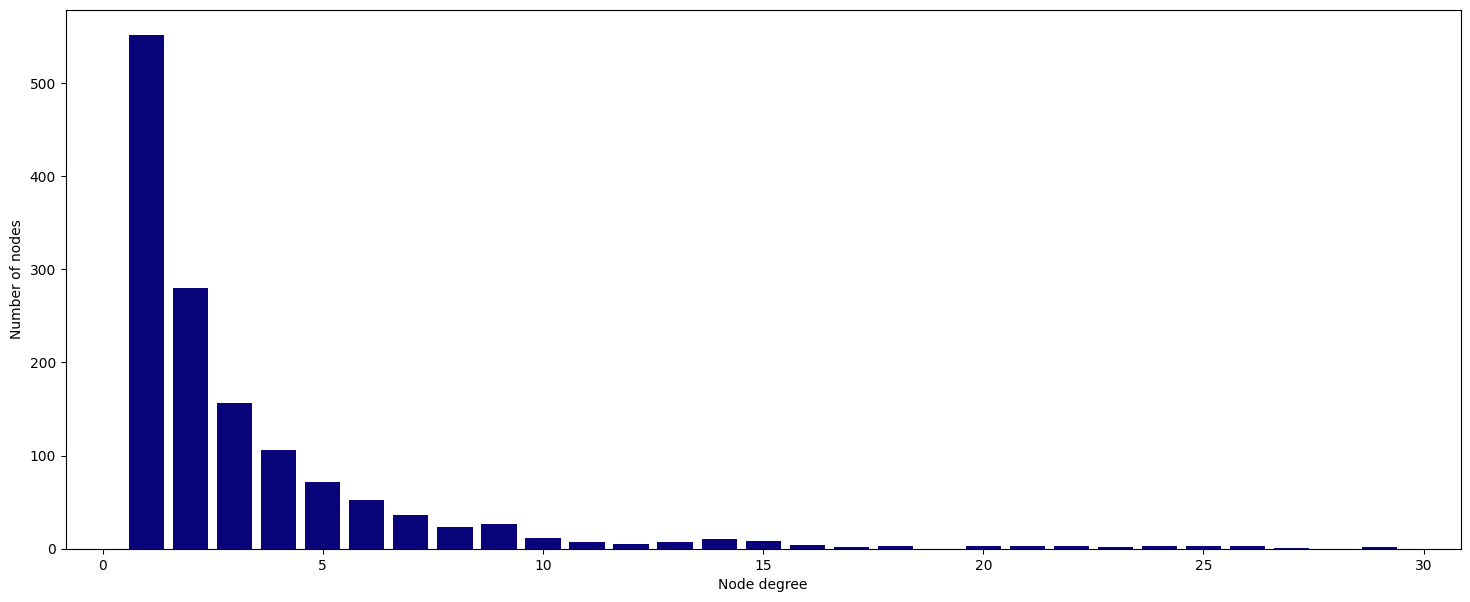

In [25]:
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(graph.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

In [26]:
from torch_geometric.loader import DataLoader

In [27]:
# Determine the number of nodes
num_nodes = graph.num_nodes
num_nodes

1389

In [28]:
# Calculate the sizes of the train, validation, and test sets
train_size = int(0.8 * num_nodes)
val_size = int(0.1 * num_nodes)
test_size = num_nodes - train_size - val_size
print(train_size, val_size, test_size)

1111 138 140


In [29]:
# Create random permutations of node indices
perm = torch.randperm(num_nodes)

# Create boolean masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[perm[:train_size]] = True
val_mask[perm[train_size:train_size + val_size]] = True
test_mask[perm[train_size + val_size:]] = True

# Add the masks to the graph object
graph.train_mask = train_mask
graph.val_mask = val_mask
graph.test_mask = test_mask

print(graph) #now the graph contains the masks.

Data(x=[1389, 44], edge_index=[2, 4649], edge_attr=[4649, 1], y=[1389], train_mask=[1389], val_mask=[1389], test_mask=[1389])


## 5. Prepare models

In [30]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv

In [31]:
class GAT(torch.nn.Module):
    """
    Graph Attention network
    """
    def __init__(self, dim_in, dim_h, dim_out, n_heads):
        super(GAT, self).__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads = n_heads)
        self.norm1 = torch.nn.LayerNorm(dim_h * n_heads)
        self.gat2 = GATv2Conv(dim_h*n_heads, dim_out, heads = 1)
        self.linear = torch.nn.Linear(dim_out, dim_out)

    def forward(self, x, edge_index):
        x1 = F.dropout(x, p = 0.5, training = self.training)
        x = self.gat1(x1, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x, negative_slope=0.02)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.gat2(x, edge_index)
        x = self.linear(x)
        return x, F.log_softmax(x, dim=1)

Graph Convolutional Network

In [32]:
dim_in = graph.x.size(1)  
dim_h = 20 
dim_out = len(graph.y.unique()) # Number of classes 
n_heads = 16  

# Create an instance of your GAT model
model = GAT(dim_in, dim_h, dim_out, n_heads)
untrained = GAT(dim_in, dim_h, dim_out, n_heads)

In [33]:
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(),weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
n_epochs = 200

In [34]:
print(model)

GAT(
  (gat1): GATv2Conv(44, 20, heads=16)
  (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
  (gat2): GATv2Conv(320, 4, heads=1)
  (linear): Linear(in_features=4, out_features=4, bias=True)
)


In [35]:
def train(model, graph, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out, log_probs = model(graph.x.float(), graph.edge_index)
    loss = criterion(log_probs[graph.train_mask], graph.y[graph.train_mask]) #only compute the loss on the train nodes.
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, graph, criterion, mask): #mask parameter added.
    model.eval()
    with torch.no_grad():
        out, log_probs = model(graph.x.float(), graph.edge_index)
        loss = criterion(log_probs[mask], graph.y[mask]) #use the mask parameter.
    return loss.item()

# Training loop
epochs = 200

for epoch in range(epochs):
    train_loss = train(model, graph, optimizer, criterion)
    val_loss = test(model, graph, criterion, graph.val_mask) #pass the validation mask
    test_loss = test(model, graph, criterion, graph.test_mask) #pass the test mask
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/200, Train Loss: 1.2282, Val Loss: 1.0556, Test Loss: 1.1302
Epoch 2/200, Train Loss: 1.2060, Val Loss: 1.0266, Test Loss: 1.1036
Epoch 3/200, Train Loss: 1.1954, Val Loss: 1.0064, Test Loss: 1.0858
Epoch 4/200, Train Loss: 1.1816, Val Loss: 0.9905, Test Loss: 1.0708
Epoch 5/200, Train Loss: 1.1742, Val Loss: 0.9776, Test Loss: 1.0554
Epoch 6/200, Train Loss: 1.1627, Val Loss: 0.9666, Test Loss: 1.0407
Epoch 7/200, Train Loss: 1.1414, Val Loss: 0.9578, Test Loss: 1.0264
Epoch 8/200, Train Loss: 1.1355, Val Loss: 0.9513, Test Loss: 1.0133
Epoch 9/200, Train Loss: 1.1153, Val Loss: 0.9468, Test Loss: 1.0009
Epoch 10/200, Train Loss: 1.1041, Val Loss: 0.9433, Test Loss: 0.9905
Epoch 11/200, Train Loss: 1.1020, Val Loss: 0.9389, Test Loss: 0.9811
Epoch 12/200, Train Loss: 1.1008, Val Loss: 0.9334, Test Loss: 0.9718
Epoch 13/200, Train Loss: 1.0945, Val Loss: 0.9266, Test Loss: 0.9624
Epoch 14/200, Train Loss: 1.0652, Val Loss: 0.9175, Test Loss: 0.9537
Epoch 15/200, Train Loss: 1.0

In [36]:
from sklearn.manifold import TSNE

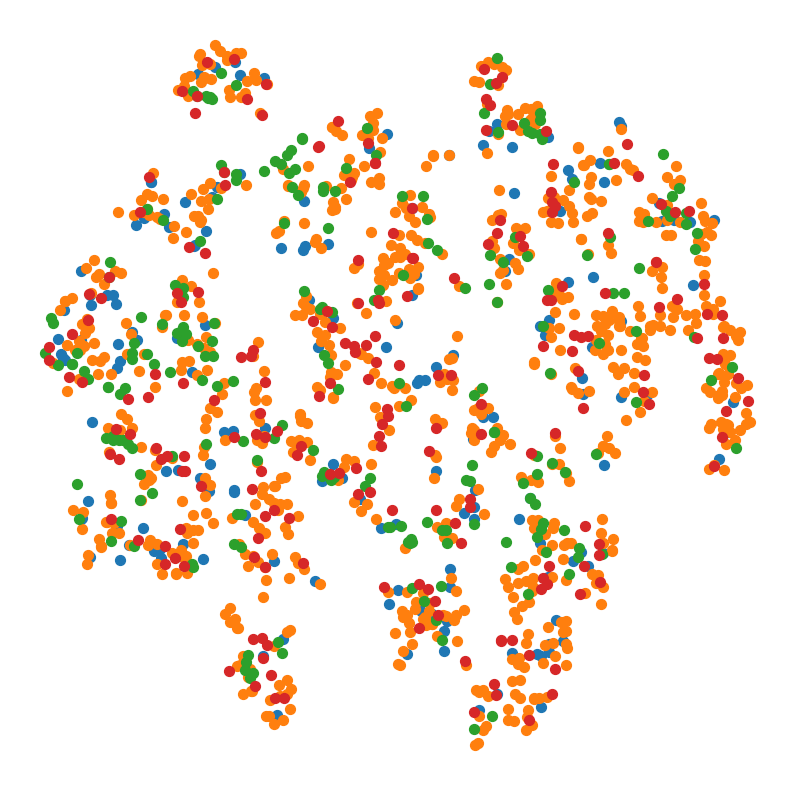

In [38]:
# Get embeddings
h, _ = untrained(graph.x.float(), graph.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

unique_labels = np.unique(graph.y)
labels = ['Moderate Poor', 'Non-vulnerable', 'Severe Poor', 'Vulnerable']

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
# Scatter plot with different colors for each class
for label in unique_labels:
    indices = graph.y == label
    plt.scatter(tsne[indices, 0], tsne[indices, 1], s=50, label=labels[label])
plt.show()

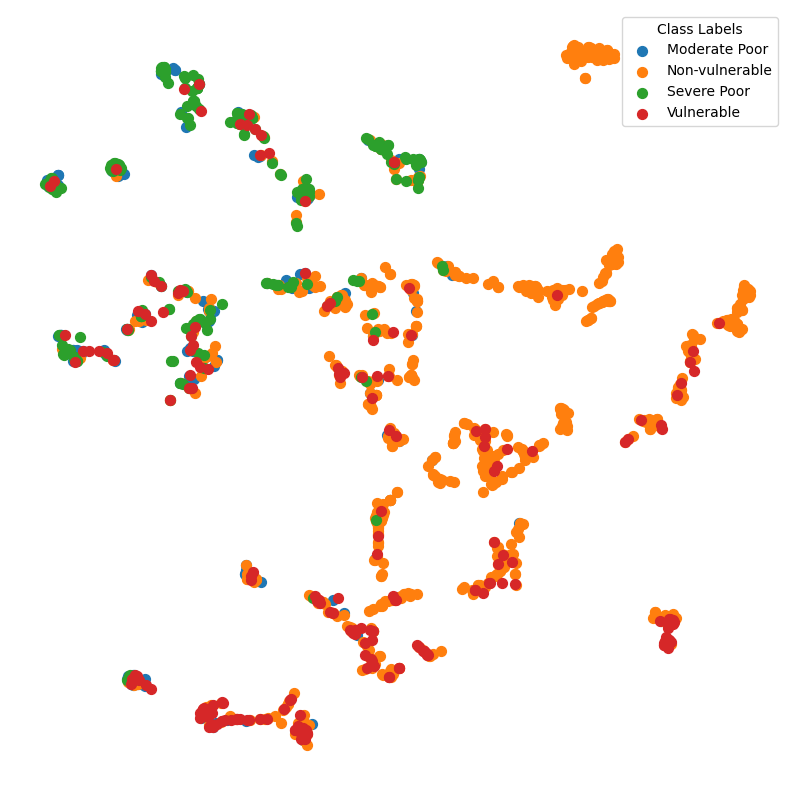

In [39]:
h, _ = model(graph.x.float(), graph.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

unique_labels = np.unique(graph.y)
labels = ['Moderate Poor', 'Non-vulnerable', 'Severe Poor', 'Vulnerable']

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
# Scatter plot with different colors for each class
for label in unique_labels:
    indices = graph.y == label
    plt.scatter(tsne[indices, 0], tsne[indices, 1], s=50, label=labels[label])
# Add legend
plt.legend(title="Class Labels", loc="upper right")
plt.show()
plt.show()